# Wind Turbine Power Curve Estimation

## Introduction

The power curve of a wind turbine is a graph that indicates how large the electrical power output will be for the turbine at different wind speeds. The figure below shows a sketch a how the power output from a wind turbine varies with steady wind speed.

<img src="power.png">

The wind turbine power curve shows the relationship between the wind turbine power and hub height wind speed. It essentially captures the wind turbine performance. Hence it plays an important role in condition monitoring and control of wind turbines. Power curves made available by the manufacturers help in estimating the wind energy potential in a candidate site. Accurate models of power curve serve as an important tool in wind power forecasting and aid in wind farm expansion. 

### Data

This data is an actual operational dataset of an inland wind turbine which is freely available on TAMU Library. The data were collected from July 30, 2010 through July 31, 2011. The data also has environemntal variables collected from met masts.  

The attributes in the file are:

- V: wind speed (m/s),
- D: wind direction (degree),
- rho: air density (kg/m^3),
- I: turbulence intensity,
- Sb: below-hub wind shear,
- y: normalized power output relative to the rated power (%).


### Objective

Objective of this project is to perform independent analysis of the wind-turbine data and predict the power curve of a wind turbine.

## Importing Libraries and Data

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from windrose import WindroseAxes
import calendar
import warnings
warnings.filterwarnings("ignore")

#model building
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from IPython.display import SVG
from graphviz import Source
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor

### Data

In [3]:
df = pd.read_csv("C:\\Users\\archd\\OneDrive\\Desktop\\Projects\\Manufacturing\\Wind-turbine\\Inland Wind Farm Dataset1(WT1).csv")
df.head()

,Sequence No.,V,D,air density,I,S_b,y (% relative to rated power)
0,1,7.96,138.9,1.140224,0.090452,0.266512,39.315152
1,2,8.19,140.6,1.140522,0.083028,0.286167,45.745455
2,3,7.20,139.3,1.140771,0.098611,0.339321,38.212121
3,4,6.81,137.4,1.141186,0.101322,0.375815,28.218182
4,5,5.09,137.5,1.141464,0.165029,0.303472,12.721212


In [4]:
df.tail()

,Sequence No.,V,D,air density,I,S_b,y (% relative to rated power)
47537,47538,4.13,231.0,1.202602,0.075061,0.115917,0.793939
47538,47539,4.54,233.5,1.202525,0.063877,0.298002,2.557576
47539,47540,4.14,231.8,1.203006,0.079710,0.149803,2.503030
47540,47541,3.94,226.3,1.202999,0.114213,0.263033,0.454545
47541,47542,3.88,226.1,1.203409,0.074742,0.154067,0.381818


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47542 entries, 0 to 47541
Data columns (total 7 columns):
Sequence No.                     47542 non-null int64
V                                47542 non-null float64
D                                47542 non-null float64
air density                      47542 non-null float64
I                                47542 non-null float64
S_b                              47542 non-null float64
y (% relative to rated power)    47542 non-null float64
dtypes: float64(6), int64(1)
memory usage: 2.5 MB


The data has total 47542 observations and 7 columns and it does not have any null values.

## Exploratory Data Analysis

Let me start by renaming the features for ease of access

In [6]:
df.rename(columns = {"Sequence No.":"seq", "V":"velocity", "D":"direction", "air density": "air_density", "I":"turb_intensity", "S_b":"wind_shear", "y (% relative to rated power)":"relative_power"}, inplace = True)
df.columns

Index(['seq', 'velocity', 'direction', 'air_density', 'turb_intensity',
       'wind_shear', 'relative_power'],
      dtype='object')

I am interested in carrying out analysis on a monthly basis so I need to assign month to observations. The data were recorded from July 30, 2010 to July 31, 2011. Since, I do not have timestamps I will keep assigning a sequence of (47542/12 ~) 3961 observations to a months starting from August to July.  

In [7]:
df["month"] = np.nan

for i in range(0, 12):
    
    if i in range(0, 5):
        m = i + 8
    else:
        m = i - 4
    
    df["month"].iloc[i*3961: (i+1)*3961] = m
    
#filling remaining 10 observations as july
df["month"].fillna(7, inplace= True);

C:\Users\archd\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


#### Monthly Wind Speed Distribution

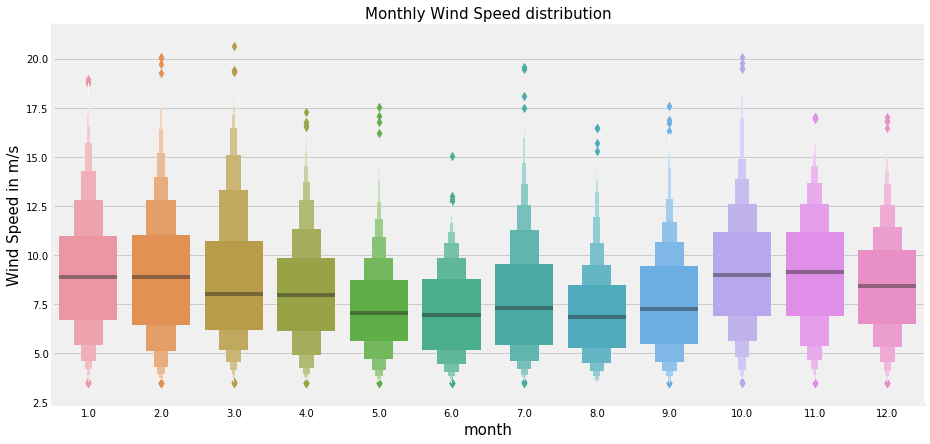

In [8]:
sns.catplot(x = "month" , y="velocity", kind="boxen", data=df, height=6, aspect=13/6)
plt.xlabel('month', fontsize=15)
plt.ylabel('Wind Speed in m/s', fontsize=15)
plt.title('Monthly Wind Speed distribution', fontsize=15)
plt.show();

As we can see there is not a significant difference in wind speed.

#### Let's plot wind speed in different wind direction

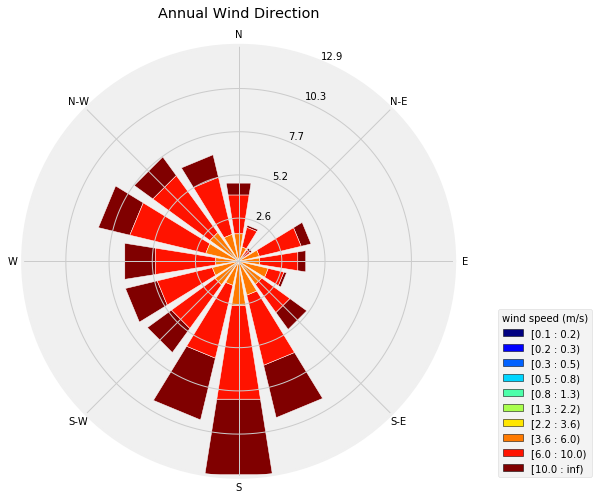

In [9]:
fig = plt.figure(figsize=(12, 10))

rect = [0.5, 0.1, 0.5, 0.75]
ax = WindroseAxes(fig, rect)
fig.add_axes(ax)
ax.bar(df.direction, df.velocity, normed=True, opening=0.8, edgecolor='white', bins=np.logspace(-1, 1, 10))
ax.set_title("Annual Wind Direction")

ax.set_legend()
ax.legend(title="wind speed (m/s)", loc=(1.1, 0));

As we can see, wind speed in the south direction is very high compared to North-East direction.

#### Let's plot power curve

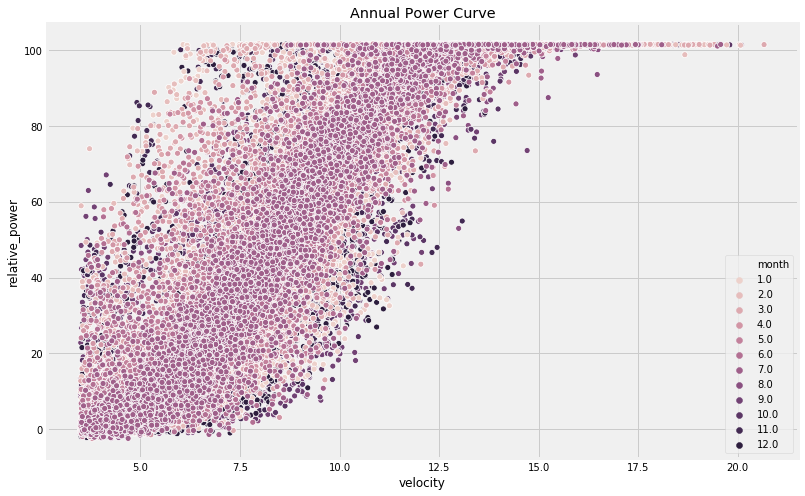

In [10]:
plt.figure(figsize = (12,8))
sns.scatterplot(x = df.velocity, y = df.relative_power, hue = df.month, legend="full")
plt.title("Annual Power Curve")
plt.show()

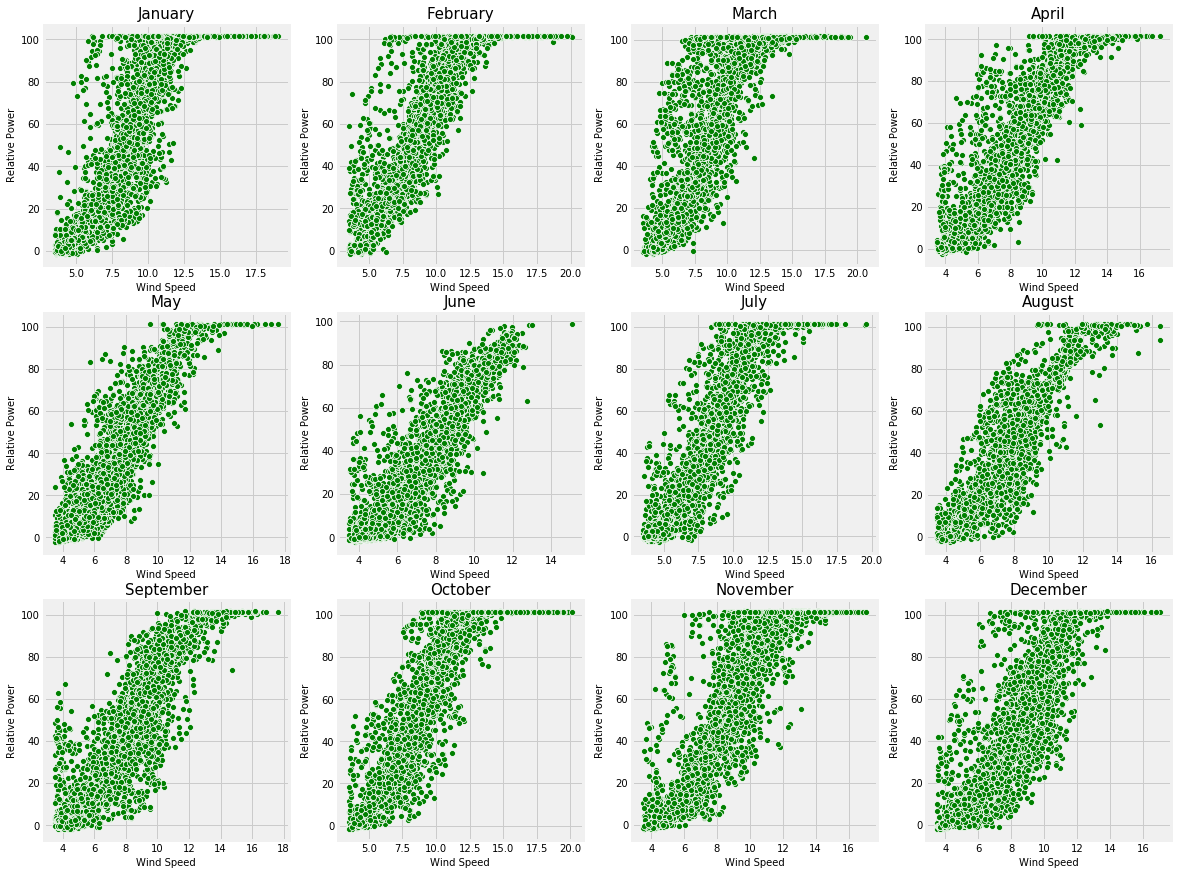

In [11]:
plt.figure(figsize = (18,15))
plt.title("Monthly Power Curve")
for i in range(1,13):
    plt.subplot(3, 4, i)
    sns.scatterplot(x = df.velocity[df.month == i], y = df.relative_power[df.month == i], color = "green")
    plt.xlabel("Wind Speed", fontsize = 10)
    plt.ylabel("Relative Power", fontsize = 10)
    plt.title(calendar.month_name[i], fontsize = 15)

From above graph we can see that the power curves generated in different months are almost similar though there are some anomalies present. 

#### Air Density 

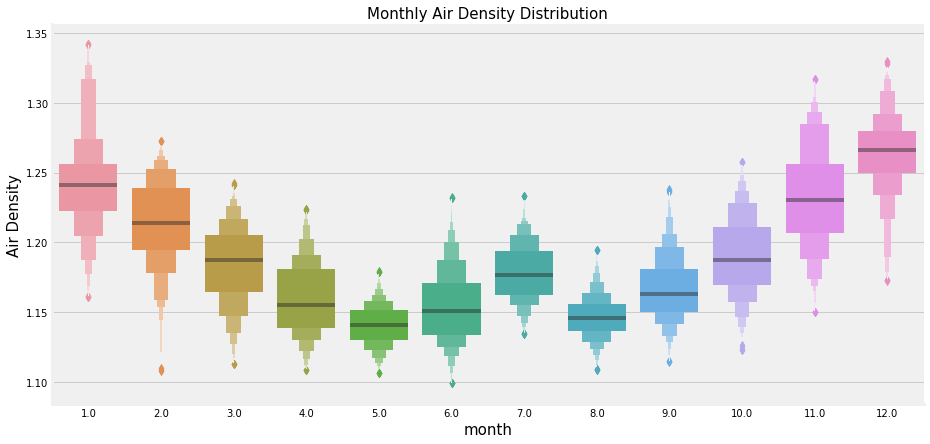

In [12]:
sns.catplot(x = "month" , y="air_density", kind="boxen", data=df, height=6, aspect=13/6)
plt.xlabel('month', fontsize=15)
plt.ylabel('Air Density', fontsize=15)
plt.title('Monthly Air Density Distribution', fontsize=15)
plt.show();

There is a significant difference in air density of different month. This is right because of in different season air density is different.

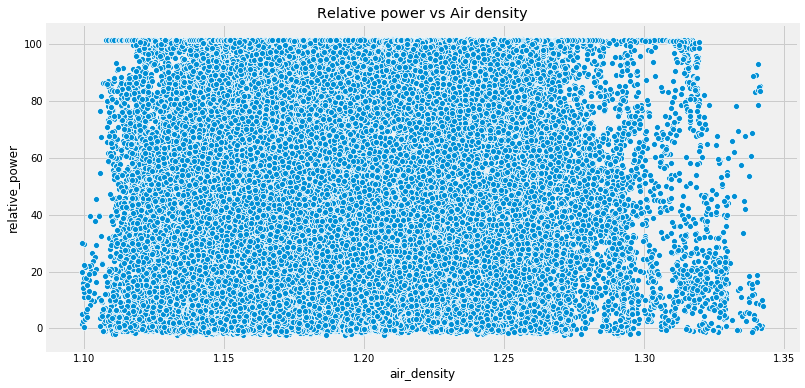

In [13]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = df.air_density, y = df.relative_power)
plt.title("Relative power vs Air density");

From above graph we can say thath air_density does not govern the relative power.

#### Turbulence Intensity

Turbulence intensity is defined as the ratio of standard deviation of fluctuating wind velocity to the mean wind speed, and it represents the intensity of wind velocity fluctuation.

Atmospheric turbulence impacts wind energy in several ways, specifically through power performance effects, impacts on turbine loads, fatigue and wake effects, and noise propagation. In the wind energy industry, turbulence is quantified with a metric called turbulence intensity – the standard deviation of the horizontal wind speed divided by the average wind speed over some time period, typically 10 minutes. If the wind fluctuates rapidly, then the turbulence intensity will be high. Conversely, steady winds have a lower turbulence intensity.

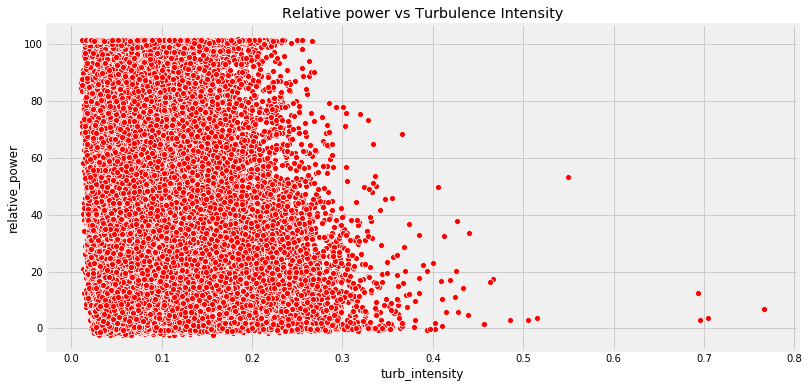

In [14]:
plt.figure(figsize = (12,6))
sns.scatterplot(df.turb_intensity, df.relative_power, color = "red")
plt.title("Relative power vs Turbulence Intensity");

As we can see as the turbulence internsity increases beyond 0.3, relative power decreases.

#### Wind Shear

Wind shear refers to a change in wind speed or direction with height in the atmosphere. It also causes the premature wind turbine gearbox failure. Let's visualize how it affects the relative power.

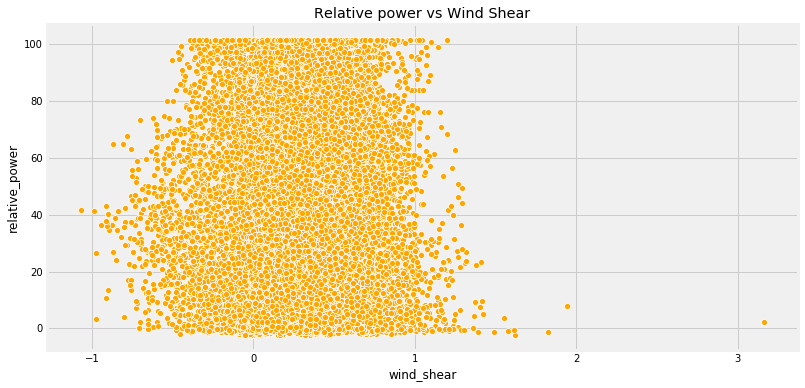

In [15]:
plt.figure(figsize = (12,6))
sns.scatterplot(df.wind_shear, df.relative_power, color = "orange")
plt.title("Relative power vs Wind Shear");

As we can see wind shear values stays in specific limits but there are some outliers. The higher the wind shear, lower the relative power.

### Correlation and Paiwise plots

In [16]:
feats = ["velocity", "wind_shear", "turb_intensity", "air_density", "relative_power"]

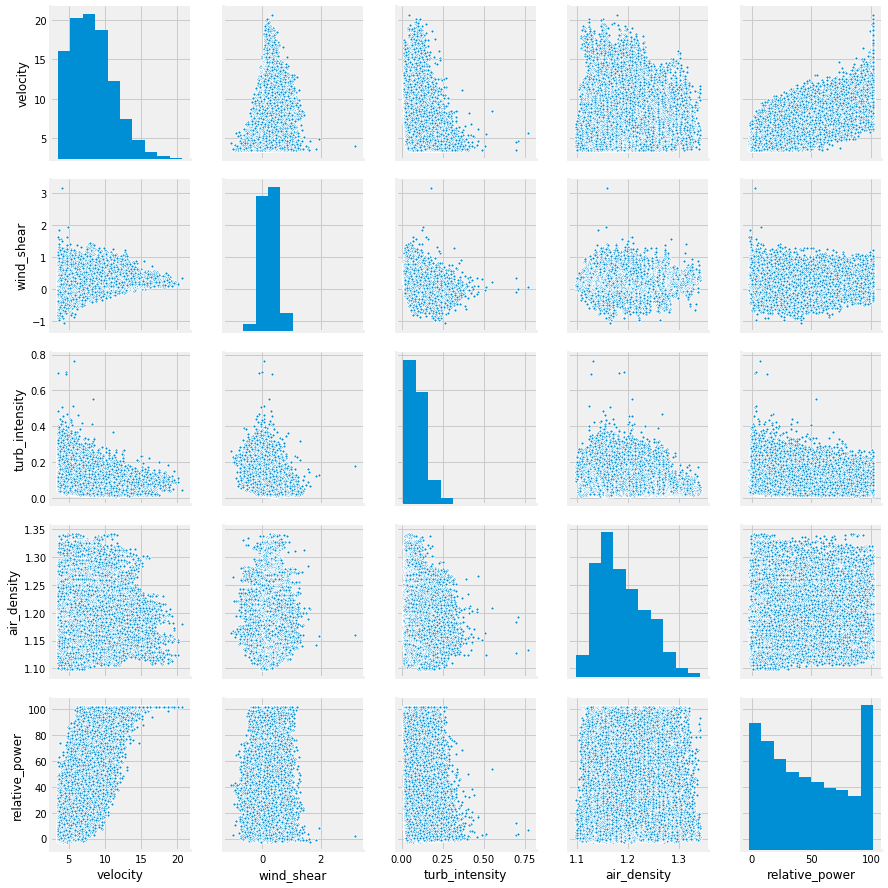

In [17]:
sns.pairplot(df[feats], markers='.');

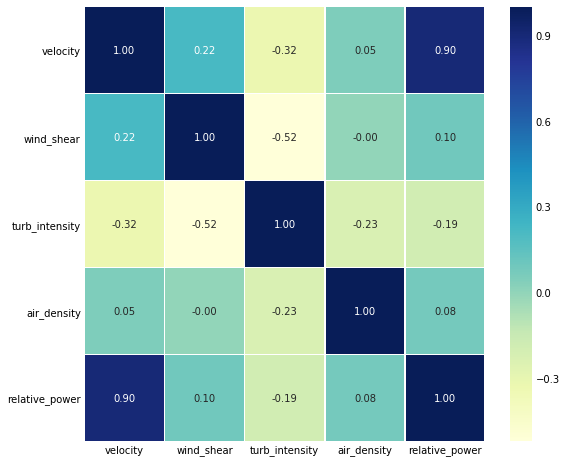

In [18]:
corr = df[feats].corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.yticks(rotation=0);
plt.show()


**Observations**
- As the velocity increases, the wind shear becomes zero and we get rated output power. 
- Air density does not affect the power output, wind shear and wind speed.
- There is a strong correlation between velocity and relative power which is a ground truth.
- Turbulence intensity negatively affects the power, wind speed and wind shear.

## Data Preprocessing

### Cyclic features

Months in a year and wind direction are not linear but cyclic features. I will have to convert them accordingly.

In [19]:
df["month_sin"] = np.sin((df.month-1)*(2*np.pi/12))
df["month_cos"] = np.cos((df.month-1)*(2*np.pi/12))

In [20]:
df["dir_sin"] = np.sin((df.direction)*np.pi/180)
df["dir_cos"] = np.cos((df.direction)*np.pi/180)

In [21]:
df.head()

,seq,velocity,direction,air_density,turb_intensity,wind_shear,relative_power,month,month_sin,month_cos,dir_sin,dir_cos
0,1,7.96,138.9,1.140224,0.090452,0.266512,39.315152,8.0,-0.5,-0.866025,0.657375,-0.753563
1,2,8.19,140.6,1.140522,0.083028,0.286167,45.745455,8.0,-0.5,-0.866025,0.634731,-0.772734
2,3,7.20,139.3,1.140771,0.098611,0.339321,38.212121,8.0,-0.5,-0.866025,0.652098,-0.758134
3,4,6.81,137.4,1.141186,0.101322,0.375815,28.218182,8.0,-0.5,-0.866025,0.676876,-0.736097
4,5,5.09,137.5,1.141464,0.165029,0.303472,12.721212,8.0,-0.5,-0.866025,0.675590,-0.737277


In [22]:
df.tail()

,seq,velocity,direction,air_density,turb_intensity,wind_shear,relative_power,month,month_sin,month_cos,dir_sin,dir_cos
47537,47538,4.13,231.0,1.202602,0.075061,0.115917,0.793939,7.0,1.224647e-16,-1.0,-0.777146,-0.629320
47538,47539,4.54,233.5,1.202525,0.063877,0.298002,2.557576,7.0,1.224647e-16,-1.0,-0.803857,-0.594823
47539,47540,4.14,231.8,1.203006,0.079710,0.149803,2.503030,7.0,1.224647e-16,-1.0,-0.785857,-0.618408
47540,47541,3.94,226.3,1.202999,0.114213,0.263033,0.454545,7.0,1.224647e-16,-1.0,-0.722967,-0.690882
47541,47542,3.88,226.1,1.203409,0.074742,0.154067,0.381818,7.0,1.224647e-16,-1.0,-0.720551,-0.693402


### Feature Scaling

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [23]:
feats = ["velocity", "wind_shear", "turb_intensity", "air_density", "month_sin", "month_cos", "dir_sin", "dir_cos"]

In [24]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df[feats] = min_max_scaler.fit_transform(df[feats])
df.head()

,seq,velocity,direction,air_density,turb_intensity,wind_shear,relative_power,month,month_sin,month_cos,dir_sin,dir_cos
0,1,-0.480186,138.9,-0.662035,-0.788857,-0.369050,39.315152,8.0,-0.5,-0.866025,0.657375,-0.753563
1,2,-0.453380,140.6,-0.659585,-0.808509,-0.359762,45.745455,8.0,-0.5,-0.866025,0.634731,-0.772734
2,3,-0.568765,139.3,-0.657538,-0.767261,-0.334643,38.212121,8.0,-0.5,-0.866025,0.652098,-0.758134
3,4,-0.614219,137.4,-0.654123,-0.760086,-0.317397,28.218182,8.0,-0.5,-0.866025,0.676876,-0.736097
4,5,-0.814685,137.5,-0.651839,-0.591451,-0.351584,12.721212,8.0,-0.5,-0.866025,0.675590,-0.737277


### Train-Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df[feats], df.relative_power, test_size=0.05, random_state=42)

In [26]:
print("Train df shape:", X_train.shape)
print("Test df shape:", X_test.shape)

Train df shape: (45164, 8)
Test df shape: (2378, 8)


## Model Building

### Baseline Model: Linear Regression

In [27]:
model = LinearRegression(normalize = True, fit_intercept=True)
lm = model.fit(X_train, y_train)
lm.coef_

array([ 94.08870944, -16.89273235,  16.83865259,   8.00278877,
         0.27254735,  -0.8168526 ,   3.23928581,  -3.21433703])

In [28]:
lm.intercept_

98.636477308597

In [29]:
R_squared = lm.score(X_train, y_train)
print("R-squared:", R_squared)

R-squared: 0.8343190734126892


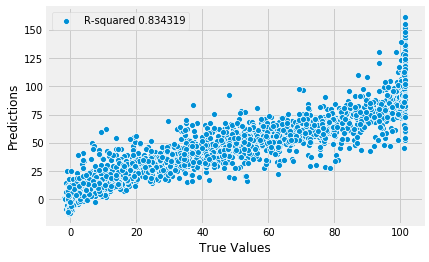

In [30]:
predictions = lm.predict(X_test)
sns.scatterplot(y_test,predictions, label = "R-squared %f" %R_squared)
plt.xlabel("True Values")
plt.ylabel("Predictions");

If the wind speed goes above rated output speed, we get only rated output power which is contstant and power does not increases linearly. Linear model fails to capture that and we need nonlinear models for that.

In [31]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 13.902418277574379


In [32]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [33]:
score = rmsle_cv(lm)
score.mean()

13.822396058606344

### Polynomial Regression : Degrees 2 to 5

In [34]:
def polyfit(degree, x_train, y, x_test):
    poly_features = PolynomialFeatures(degree=degree)
    
    X_train_poly = poly_features.fit_transform(x_train)
    poly_model = LinearRegression()
    lm_poly = poly_model.fit(X_train_poly, y)
    
    R_squared = lm_poly.score(X_train_poly, y)
    predictions = lm_poly.predict(poly_features.fit_transform(x_test))
    
    return R_squared, predictions

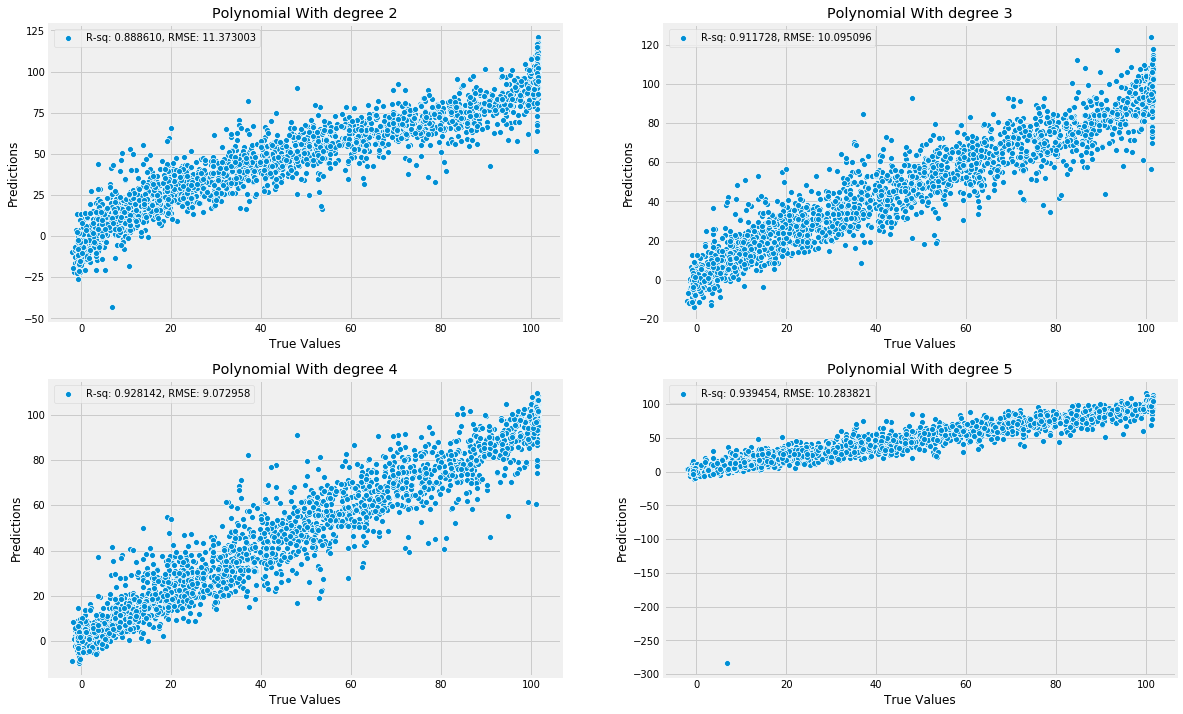

In [35]:
plt.figure(figsize=(18,12))

for i in range(2,6):
    plt.subplot(2,2,i-1).set_title('Polynomial With degree {}'.format(i))
    r2, preds = polyfit(i, X_train, y_train, X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    sns.scatterplot(y_test, preds, label = "R-sq: %f, RMSE: %f" %(r2, rmse))
    plt.xlabel("True Values")
    plt.ylabel("Predictions")

As we can see polynomial regression with degree 4 is better considering bias-variance trade off.

**Power Curve Estimation With Polynomial degree 4 Fit**

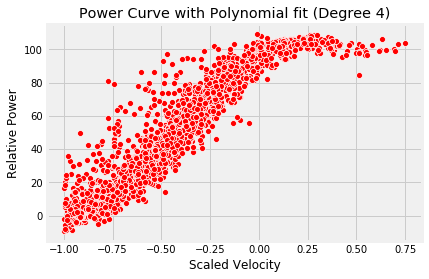

In [36]:
_ , preds =  polyfit(4, X_train, y_train, X_test)
sns.scatterplot(x = X_test.iloc[:,0], y = preds, color = "red")
plt.xlabel("Scaled Velocity")
plt.ylabel("Relative Power")
plt.title("Power Curve with Polynomial fit (Degree 4)");

As we can see, our predictions still go outside of our range [0, 100] which is not right.

### Lasso Regression 

In [37]:
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

In [38]:
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []

for a in alpha:
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
np.shape(coefs)

(10, 8)

Text(0, 0.5, 'weights')

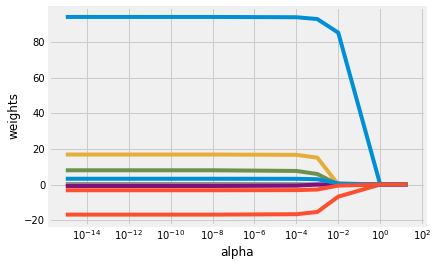

In [39]:
ax = plt.gca()
ax.plot(alpha, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [40]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)

print("Alpha=", lassocv.alpha_)

lasso.fit(X_train, y_train)
print("Rmse = ",np.sqrt(mean_squared_error(y_test, lasso.predict(X_test))))

Alpha= 0.00014370249394017197
Rmse =  13.902726566557755


In [41]:
print("best model coefficients:")
pd.Series(lasso.coef_, index=feats)

best model coefficients:


velocity          93.856918
wind_shear       -16.569550
turb_intensity    16.607095
air_density        7.463878
month_sin          0.153842
month_cos         -0.551780
dir_sin            3.202483
dir_cos           -3.128213
dtype: float64

Text(0.5, 1.0, 'Lasso Regression')

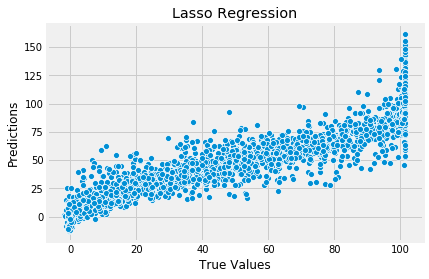

In [42]:
sns.scatterplot(y_test, lasso.predict(X_test))
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Lasso Regression")

As we can see, Lasso regression will not work as it provides linear fit to our data. 

## RandomForest Regression

In [85]:
Rforest = RandomForestRegressor(n_estimators=50, criterion='mse', max_depth=100, min_samples_split=2,
                                max_features='auto', min_impurity_decrease=0.0, min_impurity_split=None)

In [86]:
Rforest.fit(X_train, y_train)

score = rmsle_cv(Rforest)
score.mean()

7.054240469810428

In [88]:
print("R-squared:", Rforest.score(X_train, y_train))

R-squared: 0.9939848410737672


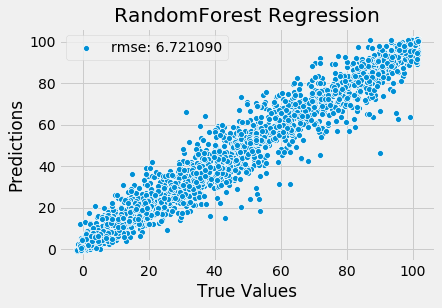

In [95]:
predictions = Rforest.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
               
sns.scatterplot(y_test, predictions, label = "rmse: %f" %rmse)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("RandomForest Regression");

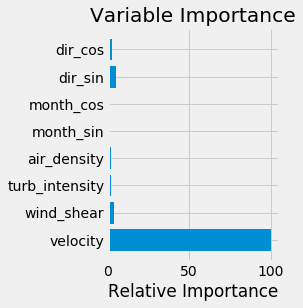

In [152]:
feature_importance = Rforest.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feats)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

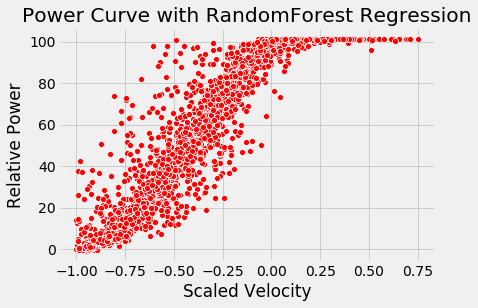

In [96]:
sns.scatterplot(x = X_test.iloc[:,0], y = predictions, color = "red")
plt.xlabel("Scaled Velocity")
plt.ylabel("Relative Power")
plt.title("Power Curve with RandomForest Regression");

## Gradient Boosting Regression

In [175]:
gbr = GradientBoostingRegressor(random_state=0)
param_grid = {
        'n_estimators': [500, 750, 1000],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1],
        'loss': ['ls'] }

model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=2, cv=3)
model.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...ate=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'n_estimators': [500, 750, 1000], 'max_depth': [3, 4, 5], 'learning_rate': [0.1], 'loss': ['ls']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [177]:
print('Gradient boosted tree regression...')
print('Best Params:')
print(model.best_params_)

Gradient boosted tree regression...
Best Params:
{'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 5, 'n_estimators': 1000}


In [178]:
params = {'n_estimators': 1000, 'max_depth': 5,
          'learning_rate': 0.1, 'loss': 'ls'}
gboost = GradientBoostingRegressor(**params)

gboost.fit(X_train, y_train)

In [181]:
print("R-squared:", gboost.score(X_train, y_train))

R-squared: 0.9778650598711162


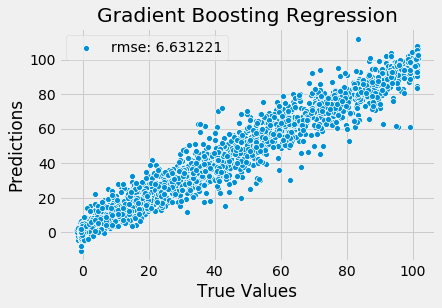

In [182]:
predictions = gboost.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
               
sns.scatterplot(y_test, predictions, label = "rmse: %f" %rmse)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Gradient Boosting Regression");

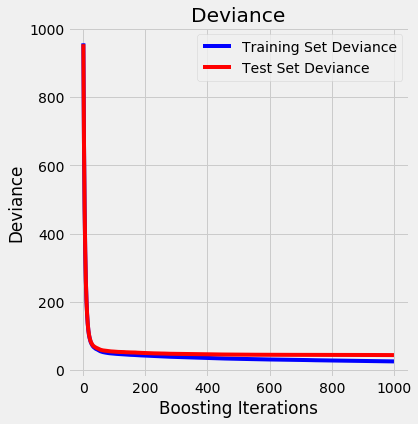

In [220]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gboost.staged_predict(X_test)):
    test_score[i] = gboost.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gboost.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance');

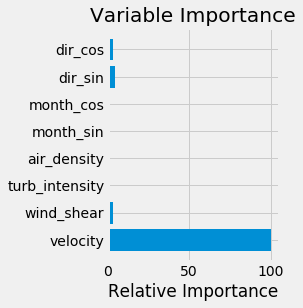

In [184]:
feature_importance = gboost.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feats)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

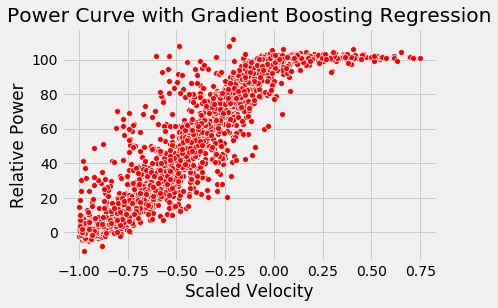

In [185]:
sns.scatterplot(x = X_test.iloc[:,0], y = predictions, color = "red")
plt.xlabel("Scaled Velocity")
plt.ylabel("Relative Power")
plt.title("Power Curve with Gradient Boosting Regression");

## XGBoost Regression

In [221]:
param_grid = {'min_child_weight':[1,2,3],
          'n_estimators':[1000],
          'max_depth': [6,8,10],
          'subsample': [0.8],
          'gamma':[0],
          'reg_alpha':[0],
          'reg_lambda':[0]
         }

In [222]:
xgb = XGBRegressor()
model = GridSearchCV(estimator=xgb, param_grid=param_grid, n_jobs=2, cv=2)
model.fit(X_train, y_train)

[20:09:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'min_child_weight': [1, 2, 3], 'n_estimators': [1000], 'max_depth': [6, 8, 10], 'subsample': [0.8], 'gamma': [0], 'reg_alpha': [0], 'reg_lambda': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [223]:
print('Extreme Gradient boosted tree regression...')
print('Best Params:')
print(model.best_params_)

Extreme Gradient boosted tree regression...
Best Params:
{'gamma': 0, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}


In [224]:
xgboost = XGBRegressor(gamma=0,                 
                 learning_rate=0.01,
                 max_depth=8,
                 min_child_weight=3,
                 n_estimators=1000,                                                                    
                 reg_alpha=0,
                 reg_lambda=0,
                 subsample=0.8,
                 seed=42) 

In [225]:
xgboost.fit(X_train,y_train);

[20:21:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [226]:
print("R-squared:", xgboost.score(X_train, y_train))

R-squared: 0.9775568026074697


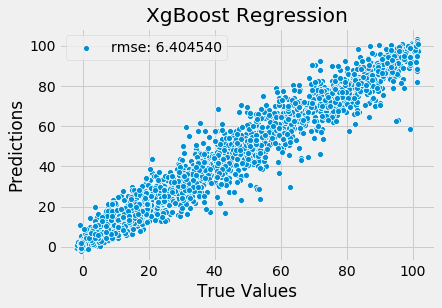

In [227]:
predictions = xgboost.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
               
sns.scatterplot(y_test, predictions, label = "rmse: %f" %rmse)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("XgBoost Regression");

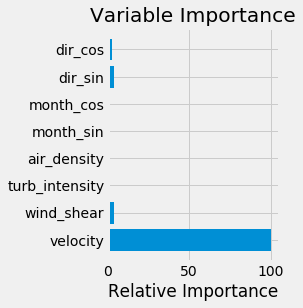

In [228]:
feature_importance = xgboost.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feats)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

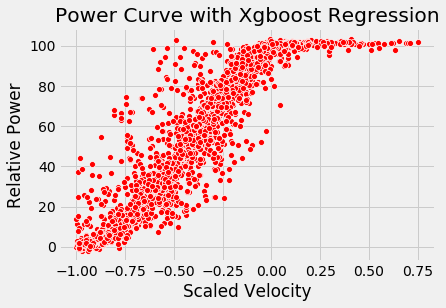

In [229]:
sns.scatterplot(x = X_test.iloc[:,0], y = predictions, color = "red")
plt.xlabel("Scaled Velocity")
plt.ylabel("Relative Power")
plt.title("Power Curve with Xgboost Regression");

## Conclusion

Here, for predicting the relative power we have two issues.
- Relative power cannot go outside the range of [0, 100].
- We know that true power curve is non-linear.

To tackle first problem while using regression problem, we can use sigmoid function but it will change the distribution of the response variable. So, to solve both of the problems I used tree based methods which gave me very good results compared to linear regression and lasso regression as they fit a straight line. Results for non linear models can be seen below.

| Model | R-squared Value | Test RMSE |
| --- | --- | --- |
| Polynomial (Degree 4) Regression | 0.92814 | 9.072 |
| Randomforest Regression | 0.99398 | 6.721 |
| Gradient Boost Regression | 0.97786 | 6.631 |
| XGBoost Regression | 0.97755 | 6.404 |


As we can see, in boosting methods bias reduces which improves the test results.


Also, feature importance plots suggests that Wind Speed (Velocity), Wind Direction and Wind Sheer are most important features for predicting the relative power.